In [18]:
from fastai.collab import *
from fastai.tabular.all import *

# Collaborative filtering

In [19]:
path = untar_data(URLs.ML_100k)

In [20]:
Path.BASE_PATH = path

In [21]:
path.ls()

(#23) [Path('u.info'),Path('u4.test'),Path('ua.base'),Path('allbut.pl'),Path('u5.base'),Path('README'),Path('u1.test'),Path('u5.test'),Path('ub.base'),Path('u3.test')...]

In [22]:
ratings = pd.read_csv(path / 'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])

In [23]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0, 1), names=('movie', 'title'), header=None)

In [28]:
movies.head(5)

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [30]:
ratings = ratings.merge(movies, on='movie')

In [31]:
ratings.groupby(['user', 'movie']).size().unstack()

movie,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
movie_1 = np.array([0.98, 0.9, -0.9])
user_1 = np.array([0.9, 0.8, -0.6])

In [33]:
(user_1 * movie_1).sum()

2.1420000000000003

In [78]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [79]:
dls.show_batch()

,user,title,rating
0,270,Romy and Michele's High School Reunion (1997),4
1,478,"Fish Called Wanda, A (1988)",3
2,798,Jungle2Jungle (1997),4
3,389,Quiz Show (1994),4
4,889,"Right Stuff, The (1983)",4
5,473,"Celluloid Closet, The (1995)",3
6,301,Happy Gilmore (1996),4
7,253,Hamlet (1996),4
8,712,"Shaggy Dog, The (1959)",3
9,731,Henry V (1989),5


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

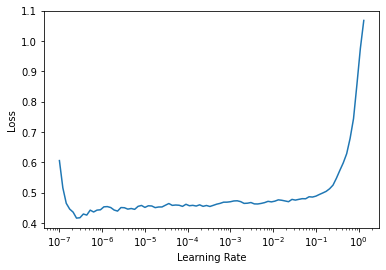

In [81]:
learn.lr_find()

In [80]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.931118,0.953378,00:06
1,0.868774,0.878353,00:06
2,0.707238,0.838144,00:06
3,0.589517,0.822283,00:06
4,0.482217,0.822286,00:06


In [82]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [89]:
movie_bias = learn.model.i_bias.weight.squeeze()
movie_weight = learn.model.i_weight.weight

In [92]:
movie_bias.shape

torch.Size([1665])

In [93]:
movie_weight.shape

torch.Size([1665, 50])

In [101]:
idxs = movie_bias.argsort(descending=True)

In [103]:
[dls.classes['title'][i] for i in idxs[:10]]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Rear Window (1954)',
 "Schindler's List (1993)",
 'As Good As It Gets (1997)',
 'Good Will Hunting (1997)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 'Usual Suspects, The (1995)',
 'Casablanca (1942)']

In [105]:
[dls.classes['title'][i] for i in idxs[-10:]]

['Striptease (1996)',
 'NeverEnding Story III, The (1994)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Solo (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Home Alone 3 (1997)',
 'Island of Dr. Moreau, The (1996)',
 'Children of the Corn: The Gathering (1996)']

In [134]:
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']

In [135]:
movie_factors[idx][None]

tensor([[ 0.6049,  1.5119,  2.2149, -1.3977,  1.6088]])

In [136]:
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

In [137]:
most_similar = distances.argsort(descending=True)

In [138]:
[dls.classes['title'][i] for i in most_similar[:5]]

['Silence of the Lambs, The (1991)',
 'Beauty and the Beast (1991)',
 'So I Married an Axe Murderer (1993)',
 'Falling in Love Again (1980)',
 'Blade Runner (1982)']

# Forecasting

In [170]:
creds = '{"username":"alexlewzey","key":"88ab6ee89ecb1ad967638268a1c49709"}'

In [171]:
from fastai.collab import *
from fastai.tabular.all import *
from kaggle import api

In [172]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.mk_write(creds)
    cred_path.chmod(0o600)

In [173]:
path = URLs.path('bluebook')
path

Path('.')

In [174]:
Path.BASE_PATH = path

In [179]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')
path.ls(file_type='text')

(#7) [Path('TrainAndValid.csv'),Path('random_forest_benchmark_test.csv'),Path('median_benchmark.csv'),Path('Valid.csv'),Path('Test.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv')]

In [187]:
df = pd.read_csv(path / 'TrainAndValid.csv', low_memory=False)
df.shape, df.head()

((412698, 53),
    SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
 0  1139246    66000.0     999089     3157         121           3.0      2004   
 1  1139248    57000.0     117657       77         121           3.0      1996   
 2  1139249    10000.0     434808     7009         121           3.0      2001   
 3  1139251    38500.0    1026470      332         121           3.0      2001   
 4  1139253    11000.0    1057373    17311         121           3.0      2007   
 
    MachineHoursCurrentMeter UsageBand         saledate  ...  \
 0                      68.0       Low  11/16/2006 0:00  ...   
 1                    4640.0       Low   3/26/2004 0:00  ...   
 2                    2838.0      High   2/26/2004 0:00  ...   
 3                    3486.0      High   5/19/2011 0:00  ...   
 4                     722.0    Medium   7/23/2009 0:00  ...   
 
   Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
 0                     NaN 

In [188]:
dep_var = 'log_sales_price'

In [190]:
df[dep_var] = np.log(df['SalePrice'])

<AxesSubplot:>

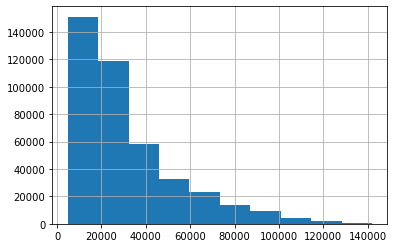

In [192]:
df['SalePrice'].hist()